[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


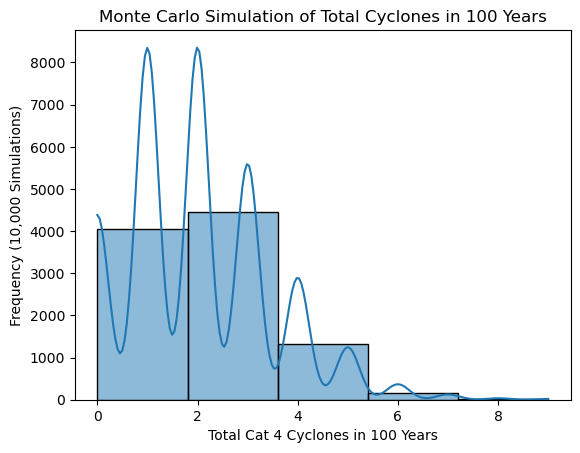

Expected number of cyclones in 100 years: 2.01
Probability of more than 3 cyclones in 100 years: 0.149


In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

lambda_cat4 = 0.02  #occurance of an individual cyclone
years = 100  # Simulate for 100 years
num_simulations = 10000  # Number of Monte Carlo runs

a = np.random.poisson(lambda_cat4, years)
print(a)

total_cyclones = [np.sum(np.random.poisson(lambda_cat4, years)) for _ in range(num_simulations)]

# Plot distribution of total cyclones over 100 years
sns.histplot(total_cyclones, bins=5, kde=True)
plt.xlabel("Total Cat 4 Cyclones in 100 Years")
plt.ylabel("Frequency (10,000 Simulations)")
plt.title("Monte Carlo Simulation of Total Cyclones in 100 Years")
plt.show()

# Compute mean and probability of extreme scenarios
mean_cyclones = np.mean(total_cyclones)
prob_more_than_3 = np.sum(np.array(total_cyclones) > 3) / num_simulations

print(f"Expected number of cyclones in 100 years: {mean_cyclones:.2f}")
print(f"Probability of more than 3 cyclones in 100 years: {prob_more_than_3:.3f}")

# Expected number of cyclones in 100 years: 

In [49]:
from climada.hazard import TCTracks
#load the datasets
tc_hist_ni = TCTracks.from_hdf5('tc_hist_ni.hdf5')
list = tc_hist_ni.subset({'category': 2})


In [50]:
from climada.hazard import TCTracks, TropCyclone, Centroids

list.equal_timestep(
    0.5
)  # Interpolation to make the track smooth and to allow applying calc_perturbed_trajectories
# Add randomly generated tracks using the calc_perturbed_trajectories method (1 per historical track)
list.calc_perturbed_trajectories(nb_synth_tracks=5)
print("num tracks hist+syn:", list.size)

num tracks hist+syn: 72


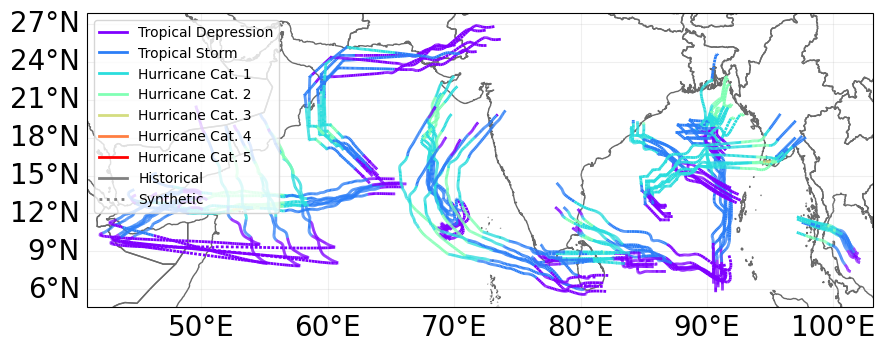

In [51]:
ax = list.plot()
ax.get_legend()._loc = 2

In [34]:
import pandas as pd
from climada.entity import Exposures

# Define exposrues here
file_name = 'exposures.xlsx'
exposures = pd.read_excel(file_name)

exp  = Exposures(exposures, ref_year=2024)
print(exp)

description: None
ref_year: 2024
value_unit: USD
crs: EPSG:4326
data: (95 entries)
           value  impf_TC                         Plant name  \
0   1.603000e+09        1          Adani Godda power station   
1   1.890239e+09        1     Aditya Aluminium power station   
2   3.784000e+07        1     Amravati Thermal Power Project   
3   4.742700e+08        1                Angul power station   
91  8.483000e+07        1  Visakhapatnam Sarda power station   
92  8.920050e+08        1          Vizag Thermal Power Plant   
93  2.812695e+09        1              Yadadri power station   
94  2.600000e+08        1             Yermarus power station   

                     geometry  
0   POINT (87.13546 24.81411)  
1   POINT (84.06059 21.74007)  
2   POINT (77.90124 21.08032)  
3   POINT (84.98055 21.12704)  
91  POINT (82.96136 17.46644)  
92  POINT (83.13888 17.56364)  
93  POINT (79.58118 16.70822)  
94  POINT (77.35612 16.29526)  


In [28]:
# Define the centroids from the exposures position
lat = exposures["latitude"].values
lon = exposures["longitude"].values
centrs = Centroids.from_lat_lon(lat, lon)

In [52]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone.from_tracks(list, centroids=centrs)

In [44]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

# impact function TC
impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])

In [45]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

hazard type: TC, hazard id: 1


In [53]:
# Compute impact
from climada.engine import ImpactCalc

imp = ImpactCalc(exp, impf_set, tc).impact(
    save_mat=True
) # Save the impact in a mat file

print(imp)

In [54]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

Aggregated average annual impact: 628379.0 $


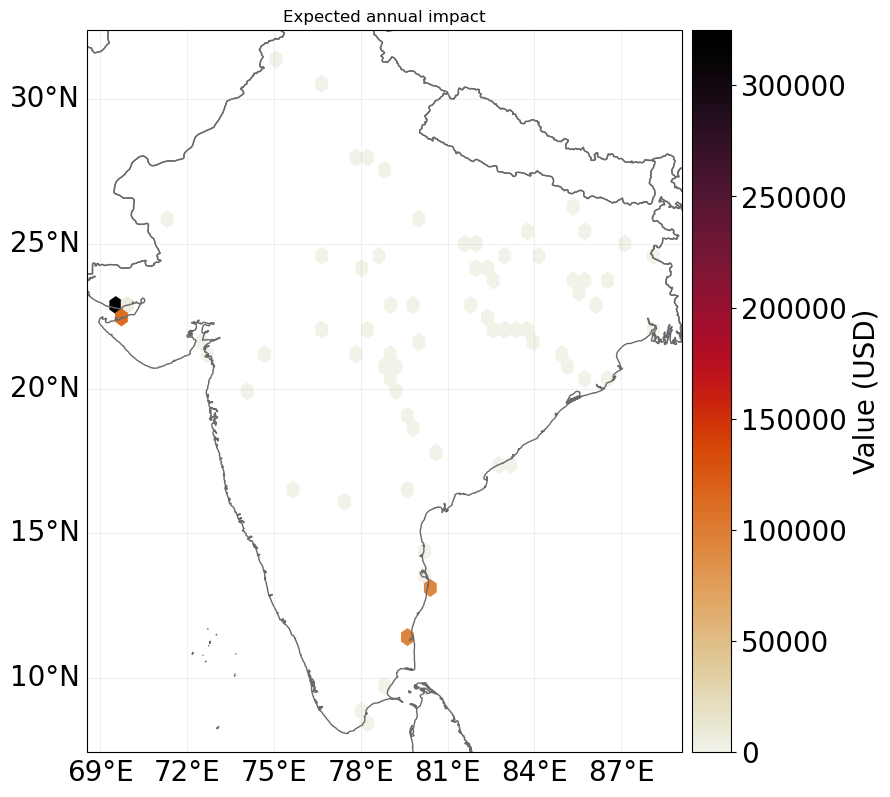

In [55]:
imp.plot_hexbin_eai_exposure(buffer=1, pop_name=False);